In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

> _"Wait until we have worked on it for a while; we will soon design the simplicity out of it!"_ Lord Hives (of Rolls Royce) remark to Whittle's explanation of the simplicity of the jet engine <cite data-cite="Not Much of an Engineer">(Hooker, 1984)

# ADRpy models - Engine Decks

An engine deck is a computerised model of an engine. The engine deck class takes real data from various engines where it has been digitised and converted into standardised forms. Manufactures of modern engines tend not to share information about their engines and so the data used tends to be from older aero engines. Despite this a good range of data for engines of different sizes is available. Note that in the conversion process some additional data specific to a particular source is lost.

The data used takes the form of performance curves. These have then been digitised and then interpolation is used to estimate data between the curves. They show some of the key aspects of an engines performance for aeronautical applications.

There are ways to model the performance of a jet engine, however the real world is much more complex and nuanced than the simple models that try and capture it. Various discrepancies resulting from the complexities and operational details of the engines can result in significant deviations from theory. This data, it allows us to get more of a handle on the performance of these engines. We can use this data to see how the actual engine's performance will affect the design choices made in aeronautical engineers.

While this data is a step up from simple theories and assumptions, it still doesn't capture all the nuances of the engine's performance for all the operating conditions. For example, engine age, fuel type and inlet temperature are not directly accounted for. These engine decks are only as sophisticated as the data used to create them.

## Contents

Turbine-based engine models:
- <span style="color:blue">class</span> [`TurbofanHiBPR`](#class-TurbofanHiBPR,-TurbofanLoBPR,-Turbojet,-Turboprop:)
: high-bypass (typically $\text{BPR}\gtrsim 1.5$ and $M<1$) turbofans
- <span style="color:blue">class</span> [`TurbofanLoBPR`](#class-TurbofanHiBPR,-TurbofanLoBPR,-Turbojet,-Turboprop:)
: low-bypass (typically $\text{BPR}\lesssim 1.5$) turbofans
- <span style="color:blue">class</span> [`Turbojet`](#class-TurbofanHiBPR,-TurbofanLoBPR,-Turbojet,-Turboprop:)
- <span style="color:blue">class</span> [`Turboprop`](#class-TurbofanHiBPR,-TurbofanLoBPR,-Turbojet,-Turboprop:)

Reciprocating engine models:
- <span style="color:blue">class</span> [`Piston`](#class-Piston,-SuperchargedPiston:)
- <span style="color:blue">class</span> [`SuperchargedPiston`](#class-Piston,-SuperchargedPiston:)

Electric motor model:
- <span style="color:blue">class</span> [`ElectricMotor`](#class-ElectricMotor:)

Custom engine decks based on real-world performance data:
- <span style="color:teal">dict</span> [`engine_catalogue`](#dict-engine_catalogue:)
- <span style="color:blue">class</span> [`EngineDeck`](#class-EngineDeck:)

## <span style="color:blue">class</span> `TurbofanHiBPR`, `TurbofanLoBPR`, `Turbojet`, `Turboprop`:
[Back to Contents ⬆️](#Contents)

A number of generic turbine-based propulsors described in [[1]](#References), including high bypass turbofans (for large airliners and cargo aircraft), mixed flow low bypass turbofans (for modern supersonic fighters), turbojets, and turboprops.

In [2]:
from ADRpy.propulsion import TurbofanHiBPR, TurbofanLoBPR, Turbojet, Turboprop

Each generic engine performance deck can estimate the thrust lapse due to change in ambient flight conditions.

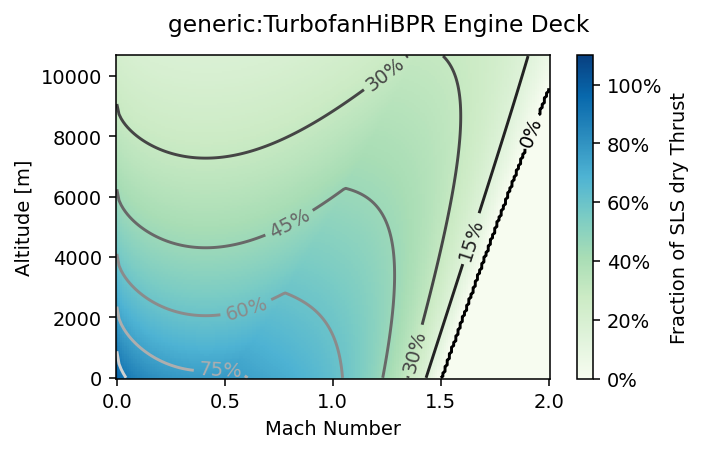

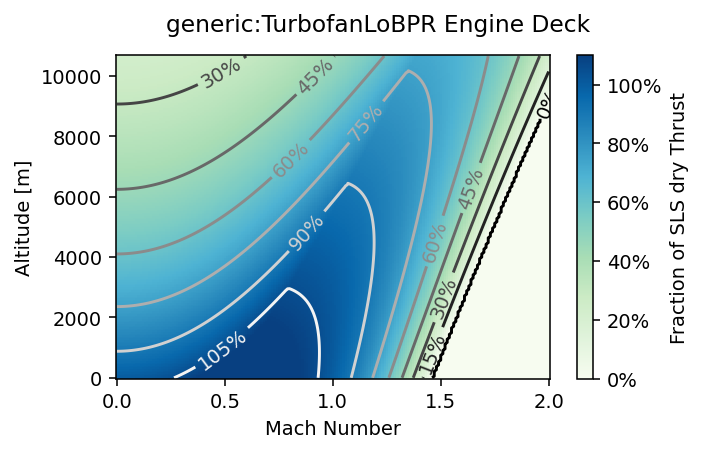

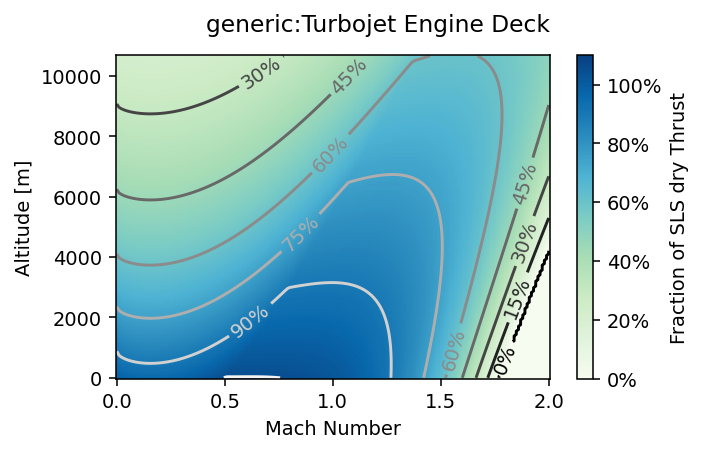

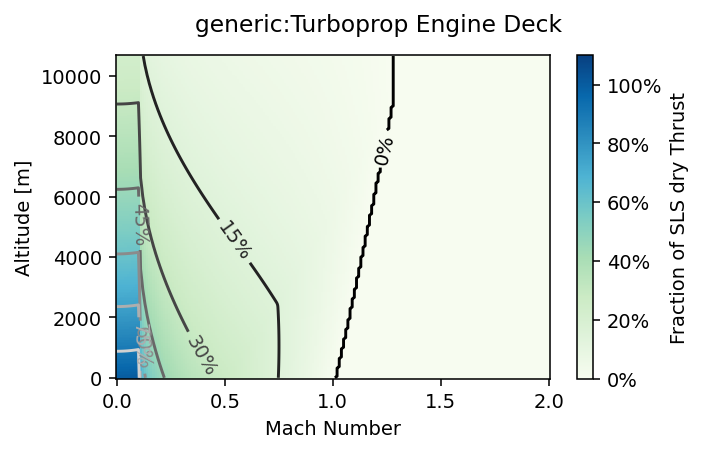

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from ADRpy import unitconversions as uc


def plot_thrustlapse(enginedeck):
    # Generate plot data
    machs = np.linspace(0, 2, 201)
    altitudes = np.linspace(0, uc.ft_m(35e3), 201)

    X, Y = np.meshgrid(machs, altitudes)
    Z = enginedeck.thrust(X, Y, norm=True)

    # Make a plot with a 2D "heat map"
    fig, ax = plt.subplots(dpi=140, figsize=(5, 3))
    im = ax.pcolormesh(X, Y, Z, cmap="GnBu", vmin=0, vmax=1.1)
    cs = ax.contour(X, Y, Z, cmap="binary_r", vmin=0, vmax=1.1)

    # Plot labels
    fig.suptitle(f"{enginedeck.name} Engine Deck")
    fig.colorbar(im, ax=ax, label="Fraction of SLS dry Thrust", format=lambda x, _: f"{x:.0%}")
    ax.clabel(cs, fmt=lambda x: f"{x:.0%}")
    ax.set_xlabel("Mach Number")
    ax.set_ylabel("Altitude [m]")

    plt.show()
    return

# Plot the thrust lapse maps for all of Mattingly's turbomachines
turbomachines = [TurbofanHiBPR, TurbofanLoBPR, Turbojet, Turboprop]
_ = [plot_thrustlapse(enginedeck=x) for x in turbomachines]

Moreover, some turbomachine are capable of enhanced performance (thanks to afterburning).
Presently this improved performance is only available to aircraft in the takeoff phase using the sea level takeoff thrust method, `.thrust_slto(mach)`.

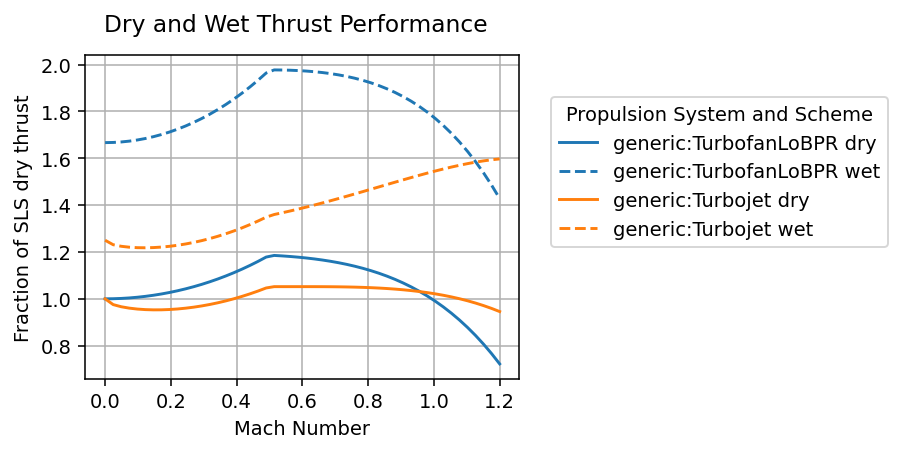

In [4]:
fig, ax = plt.subplots(dpi=140, figsize=(4, 3))

machs = np.linspace(0, 1.2)

for turbomachine in turbomachines:
    thrust = turbomachine.thrust(machs, altitude_m=0)
    thrust_slto = turbomachine.thrust_slto(machs)
    if (thrust == thrust_slto).all():
        continue
    
    line2d, = ax.plot(machs, thrust, label=f"{turbomachine.name} dry")
    ax.plot(machs, thrust_slto, c=line2d.get_c(), ls="--", label=f"{turbomachine.name} wet")

fig.suptitle("Dry and Wet Thrust Performance")
ax.legend(title="Propulsion System and Scheme", bbox_to_anchor=(1.05, 0.9), loc="upper left")
ax.set_xlabel("Mach Number")
ax.set_ylabel("Fraction of SLS dry thrust")
ax.grid()
plt.show()

## <span style="color:blue">class</span> `Piston`, `SuperchargedPiston`:
[Back to Contents ⬆️](#Contents)

The performance lapse of turbine-based engines can be modelled as a function of Mach number and altitude, neatly accounting for the stagnation quantities due to ram-air effects in the steady (air) flow system.
Reciprocating engines, on the other hand, are not as strongly correlated with dynamic pressure as they are static pressure.

In [5]:
from ADRpy.propulsion import Piston, SuperchargedPiston

For this reason, basic piston engine models are simply a function of the density ratio (against standard day sea level).

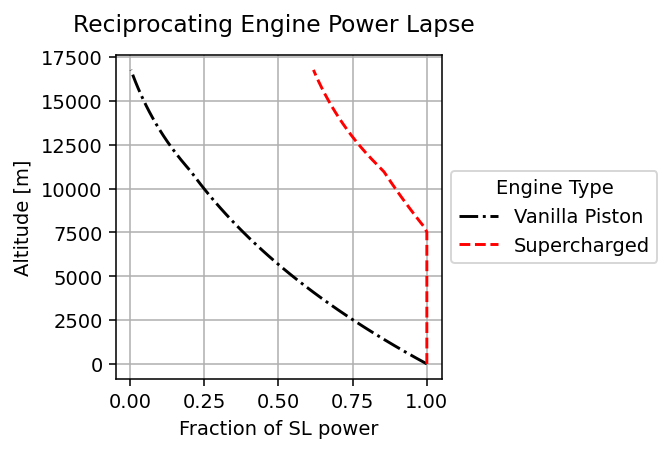

In [6]:
altitudes = np.linspace(0, uc.ft_m(55e3))

fig, ax = plt.subplots(dpi=140, figsize=(3, 3))

powerkwargs = {"mach": None, "altitude_m":altitudes}
ax.plot(Piston.shaftpower(**powerkwargs), altitudes, label="Vanilla Piston", c="k", ls="-.")
ax.plot(SuperchargedPiston.shaftpower(**powerkwargs), altitudes, label="Supercharged", c="r", ls="--")

fig.suptitle("Reciprocating Engine Power Lapse")
ax.set_xlabel("Fraction of SL power")
ax.set_ylabel("Altitude [m]")
ax.legend(title="Engine Type", bbox_to_anchor=(1, 0.5), loc="center left")
ax.grid()

plt.show()

## <span style="color:blue">class</span> `ElectricMotor`:
[Back to Contents ⬆️](#Contents)

Electric motors are a kind of engine in which the motive force is generated from stored electrical energy.
While motors may get hot during operation (which can impact efficiency among other things), they tend to be actively cooled in some way (especially ones based on super conducting technology).

Once a motor has reached steady state performance, then providing the cooling system is doing its job, the motor shaft power output is independent of both Mach number and altitude (which cannot be said for the system as a whole).

In [7]:
from ADRpy.propulsion import ElectricMotor

We'll compare the power lapse of a hypothetical electric motor (to its sea-level maximum continuous power), to some piston engines.

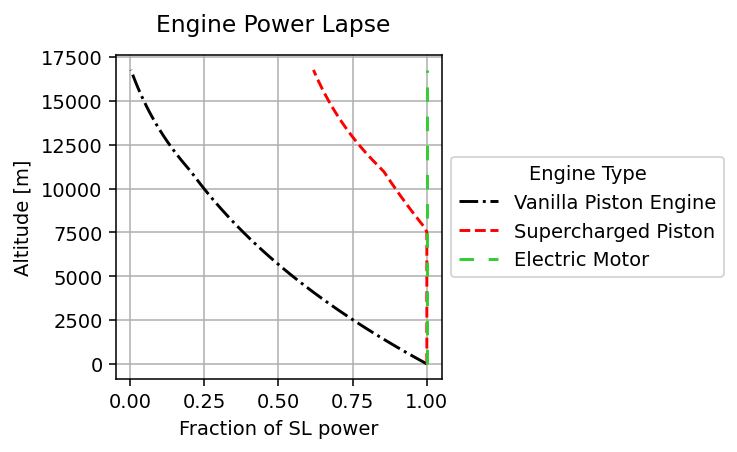

In [8]:
altitudes = np.linspace(0, uc.ft_m(55e3))

fig, ax = plt.subplots(dpi=140, figsize=(3, 3))

ax.plot(Piston.shaftpower(**powerkwargs), altitudes, label="Vanilla Piston Engine", c="k", ls="-.")
ax.plot(SuperchargedPiston.shaftpower(**powerkwargs), altitudes, label="Supercharged Piston", c="r", ls="--")
ax.plot(ElectricMotor.shaftpower(**powerkwargs), altitudes, label="Electric Motor", c="limegreen", ls=(0, (5, 5)))

fig.suptitle("Engine Power Lapse")
ax.set_xlabel("Fraction of SL power")
ax.set_ylabel("Altitude [m]")
ax.legend(title="Engine Type", bbox_to_anchor=(1, 0.5), loc="center left")
ax.grid()

plt.show()

## <span style="color:teal">dict</span> `engine_catalogue`:
[Back to Contents ⬆️](#Contents)

We can list the propulsion systems available to a user.

In [9]:
import json
from ADRpy.propulsion import engine_catalogue

# From the engine catalogue, record each available engine along with its "type" classification
custom_map = {k: v["type"] for (k, v) in engine_catalogue.items()}

print(json.dumps(custom_map, indent=2))

{
  "JM-X57": "electricmotor",
  "YASA-750R": "electricmotor",
  "IO-540": "piston",
  "Wasp Major B13": "piston",
  "ATF3-6A": "turbofan",
  "F404-400": "turbofan",
  "FJ44": "turbofan",
  "JT8D-9": "turbofan",
  "JT9D-3": "turbofan",
  "TF30": "turbofan",
  "TFE731-2": "turbofan",
  "TFE731-5": "turbofan",
  "J52": "turbojet",
  "J60": "turbojet",
  "T56-A": "turboprop",
  "Tyne RTy.11": "turboprop"
}


## <span style="color:blue">class</span> `EngineDeck`:
[Back to Contents ⬆️](#Contents)

The `EngineDeck` class is the star of ADRpy's propulsion module.
It allows users to base propulsor behaviour off the measured performance of real engine systems.
Here we will demonstrate the capability and use of the 'JT9D-3' engine deck.

In [10]:
from ADRpy.propulsion import EngineDeck

# Instantiate using the name as it appears in the engine_catalogue
deck = EngineDeck("JT9D-3")

The Pratt & Whitney JT9D-3 is a high bypass ratio turbofan which first saw service with the Boeing 747-100.
In ADRpy, we can map out this engine's thrust performance given flight conditions (in ISA conditions).

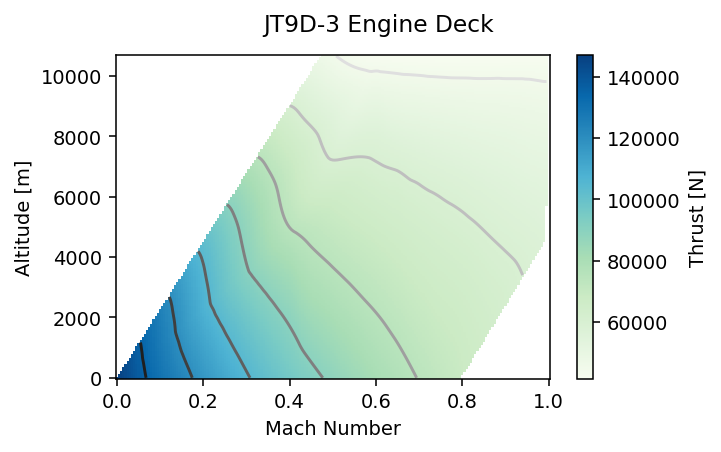

In [11]:
# Generate plot data
machs = np.linspace(0, 1, 201)
altitudes = np.linspace(0, uc.ft_m(35e3), 201)

X, Y = np.meshgrid(machs, altitudes)
Z = deck.thrust(X, Y)

# Make a plot with a 2D "heat map"
fig, ax = plt.subplots(dpi=140, figsize=(5, 3))
im = ax.pcolormesh(X, Y, Z, cmap="GnBu")
ax.contour(X, Y, Z, cmap="binary")

# Plot labels
fig.suptitle(f"{deck.name} Engine Deck")
fig.colorbar(im, ax=ax, label="Thrust [N]")
ax.set_xlabel("Mach Number")
ax.set_ylabel("Altitude [m]")

plt.show()

Engine performance is often dependent on external conditions such as freestream velocity, ambient temperature, and ambient pressure.
Combinations of these parameters often lead to a "lapse" in the engine's available thrust (or shaftpower) - which are simply computed by normalising the output with the sea-level static performance.

In [12]:
mach0_0 = deck.thrust(mach=0.0, altitude_m=0, norm=True)
mach0_4 = deck.thrust(mach=0.4, altitude_m=0, norm=True)

print(f"At sea-level/rest, the {deck.name} produces {mach0_0[0]:.0%} of its sea-level static thrust.")
print(f"At sea-level/M=0.4, the {deck.name} produces {mach0_4[0]:.0%} of its sea-level static thrust.")

At sea-level/rest, the JT9D-3 produces 100% of its sea-level static thrust.
At sea-level/M=0.4, the JT9D-3 produces 65% of its sea-level static thrust.


At the time of service, some engines made use of water injection to augment thrust during particularly demanding conditions (such as takeoff).
Let's compare the thrust available to the engine at takeoff, with and without water injection.

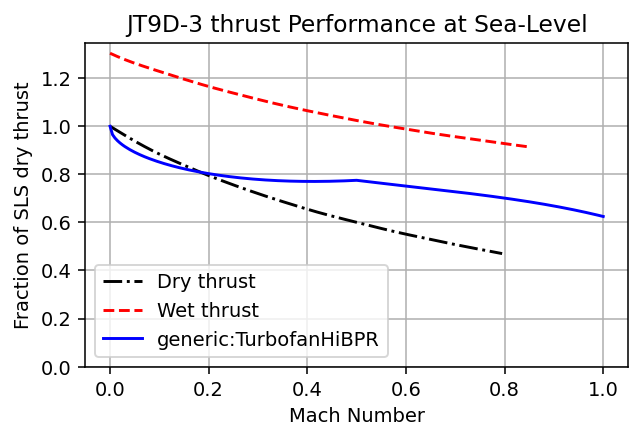

In [13]:
thrust_standard = deck.thrust(mach=machs, altitude_m=0, norm=True)
thrust_slto = deck.thrust_slto(mach=machs, norm=True)

fig, ax = plt.subplots(dpi=140, figsize=(5, 3))

ax.plot(machs, thrust_standard, label="Dry thrust", c="k", ls="-.")
ax.plot(machs, thrust_slto, label="Wet thrust", c="r", ls="--")
ax.plot(machs, TurbofanHiBPR.thrust_slto(mach=machs), label=f"{TurbofanHiBPR.name}", c="b")

ax.set_title(f"{deck.name} thrust Performance at Sea-Level")
ax.set_xlabel("Mach Number")
ax.set_ylabel("Fraction of SLS dry thrust")
ax.set_ylim(0, None)
ax.legend()
ax.grid()
plt.show()

Now lets look at an engine that does not contain a thrust augmentation system: the Tyne RTy.11.

In [14]:
deck2 = EngineDeck("Tyne RTy.11")
print(f"The {deck2.name} is a {deck2.type} engine.")

The Tyne RTy.11 is a turboprop engine.


The data provided for this engine includes the thrust from the turboprop core and the power developed by the turboshaft - but no data on the fan (cold) thrust.
In such a case, ADRpy uses a simplistic propeller efficiency model from [[1]](#References).

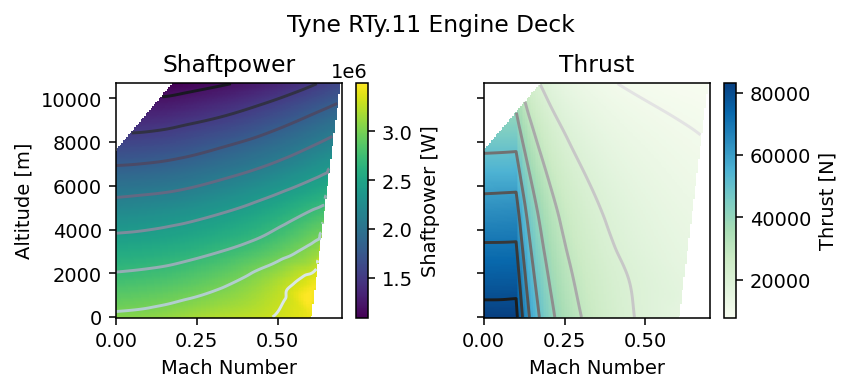

In [15]:
X, Y = np.meshgrid(machs, altitudes)
Z0 = deck2.shaftpower(X, Y)
Z1 = deck2.thrust(X, Y)

# Make a plot with a 2D "heat map"
fig, axs = plt.subplots(1, 2, dpi=140, figsize=(6, 2.5), sharex=True, sharey=True)

im0 = axs[0].pcolormesh(X, Y, Z0, cmap="viridis")
axs[0].contour(X, Y, Z0, cmap="bone")
im1 = axs[1].pcolormesh(X, Y, Z1, cmap="GnBu")
axs[1].contour(X, Y, Z1, cmap="binary")

# Plot labels
fig.suptitle(f"{deck2.name} Engine Deck")
fig.subplots_adjust(top=0.78, wspace=0.3)
fig.colorbar(im0, ax=axs[0], label="Shaftpower [W]")
fig.colorbar(im1, ax=axs[1], label="Thrust [N]")
axs[0].set_title("Shaftpower")
axs[0].set_ylabel("Altitude [m]")
axs[1].set_title("Thrust")
for ax in axs.flat:
    ax.set_xlabel("Mach Number")
    ax.set_xlim(0, 0.7)

plt.show()

We may choose to plot thrust against sea-level takeoff thrust as we did with the JT9D-3, however, since there is no thrust augmentation system - there is no effect on the developed thrust when the method is called.

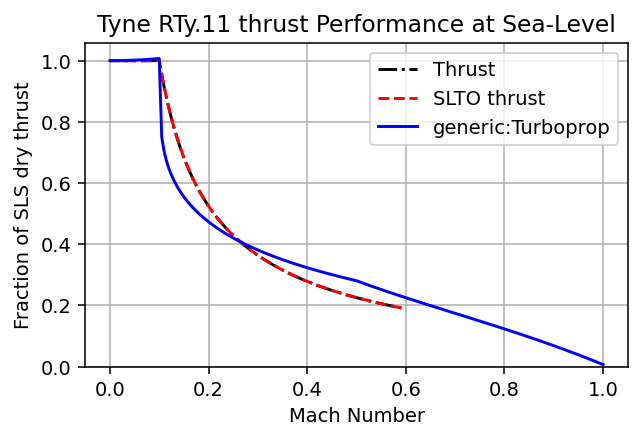

In [16]:
thrust_standard = deck2.thrust(mach=machs, altitude_m=0, norm=True)
thrust_slto = deck2.thrust_slto(mach=machs, norm=True)

fig, ax = plt.subplots(dpi=140, figsize=(5, 3))

ax.plot(machs, thrust_standard, label="Thrust", c="k", ls="-.")
ax.plot(machs, thrust_slto, label="SLTO thrust", c="r", ls="--")
ax.plot(machs, Turboprop.thrust_slto(mach=machs), label=f"{Turboprop.name}", c="b")

ax.set_title(f"{deck2.name} thrust Performance at Sea-Level")
ax.set_xlabel("Mach Number")
ax.set_ylabel("Fraction of SLS dry thrust")
ax.set_ylim(0, None)
ax.legend()
ax.grid()
plt.show()

Unsurprisingly, the curves for thrust and SLTO thrust overlap.

It should not surprise anyone at this point that the thrust output of a piston-aircraft is a function of Mach number and altitude.
However, given the relative ease with which a propeller may be changed between missions, it is much more difficult to accurately characterise the thrust performance of a propeller in a way that generalises.

For this reason, it is much more sensible to provide engine performance decks in terms of the lapse of power.
There is little need to consider the differences in lapses for the shaft power (power after transmission losses) and brake power (rotational power of the engine crankshaft).

The power lapse for a Lycoming IO-540 is shown below.

In [17]:
deck3 = EngineDeck("IO-540")
print(f"The {deck3.name} is a {deck3.type} engine.")

The IO-540 is a piston engine.


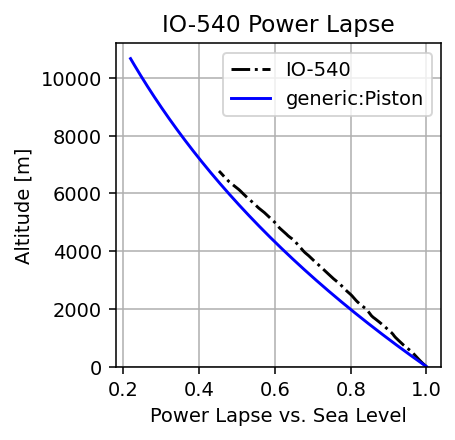

In [18]:
power = deck3.shaftpower(mach=None, altitude_m=altitudes, norm=True)

fig, ax = plt.subplots(dpi=140, figsize=(3, 3))

ax.plot(power, altitudes, label=deck3.name, c="k", ls="-.")
ax.plot(Piston.shaftpower(mach=None, altitude_m=altitudes), altitudes, label=Piston.name, c="b", ls="-")

ax.set_title(f"{deck3.name} Power Lapse")
ax.set_xlabel("Power Lapse vs. Sea Level")
ax.set_ylabel("Altitude [m]")
ax.set_ylim(0, None)
ax.legend()
ax.grid()
plt.show()

# References

[1]  J. D. Mattingly, W. H. Heiser, D. T. Pratt, *Aircraft Engine Design* 2nd ed. Reston, Virginia: AIAA, 2002. Sections 2.3.2, 3.3.2, and Appendix K.